<a href="https://colab.research.google.com/github/ASUcicilab/GIS322/blob/main/notebook/Module_5_A_Real-World_Example_Mapping_Phoenix_Crimes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phoenix Crime Data Mapping at Zip-code Level
Now we have learned two modules and are able to perform some analysis based on real-world dataset! In this exericse, we will be analyzing crime data obtained from City of Phoenix with the help of several packages:   `pandas`, `geopandas`, and `matplotlib`.

Learning objectives are:

* Retrieve (download) data from a public weibsite
* Read CSV and shapefile using `pandas` and `geopandas`
* Data cleaning
* Recap on how to convert Lat-Long to GeoDataFrame using `geopandas`'s `points_from_xy` method
* Understand the use of `group_by`, `merge` in `pandas`
* Create basic map using `geopandas` and `matplotlib`


Detailed steps are as follows:
* Download open crime data from city website (https://www.phoenixopendata.com/dataset/crime-data)
* Query all the crimes happened in 2018
* Group crimes by zip code
* Join grouped crimes in 2018 to zipcode shapefile based on zipcode value
* Make a zip-code level crime map
* Export map to image (.png) format

### 1. Importing necessary packages

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

### 2. Make sure you allow notebook to display your matplotlib plots.

In [ ]:
%matplotlib inline

### 3. Read-in your three files:
* A boundary shapefile (**az_zipcodes.shp**) of Phoex Zipcodes which contains polygon for each zipcode.
* A table (**phx_crimes.csv**) file containing a list of recent crime incidents. Each incident is geo-coded with longitude and latitude.
* A point shapefile (**AZ_cities_coords.shp**) containing a list of PHX cities, for reference.

In [ ]:
az_zip_shp = gpd.read_file("data/AZ_zipcodes/AZ_zipcodes.shp")
phx_crimes = pd.read_csv("data/phx_crimes.csv")
phx_cities_df = pd.read_csv("data/AZ_cities_coords.csv")

<ipython-input-3-6ea5517eb5cc>:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  phx_crimes = pd.read_csv("data/phx_crimes.csv")


### 4. After reading them, first of all, let's check if our files are read properly (in case of broken/badly formatted files)
* `.head()` method will display the first 5 rows of a given dataframe

In [ ]:
az_zip_shp.head() #Zipcode boundary shapefile

,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,Zipcode,geometry
0,85019,85019,B5,G6350,S,9713482,16770,+33.5088785,-112.1445137,85019,"POLYGON ((-112.15154 33.51432, -112.15153 33.5..."
1,85020,85020,B5,G6350,S,23027500,65264,+33.5673508,-112.0535909,85020,"POLYGON ((-112.03919 33.59392, -112.03904 33.5..."
2,85021,85021,B5,G6350,S,17419881,74879,+33.5594209,-112.0928747,85021,"POLYGON ((-112.11569 33.56233, -112.11609 33.5..."
3,85022,85022,B5,G6350,S,24230483,4009,+33.6272400,-112.0484143,85022,"POLYGON ((-112.07416 33.64750, -112.07416 33.6..."
4,85023,85023,B5,G6350,S,18927812,18972,+33.6341180,-112.0931632,85023,"POLYGON ((-112.11518 33.64381, -112.11501 33.6..."


<Axes: >

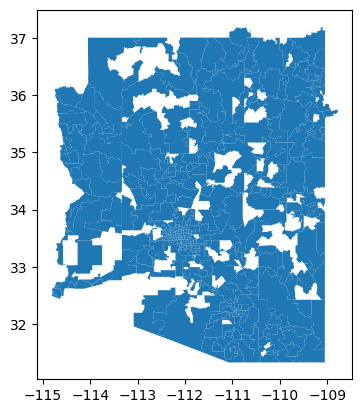

In [ ]:
az_zip_shp.plot() # a quick plot to look at those zip-code polygons

In [ ]:
phx_cities_df.head() #City locations

,StateAbbr,PlaceName,PlaceFIPS,lat,long
0,AZ,Gilbert,427400,33.310149,-111.746238
1,AZ,Chandler,412000,33.283190,-111.852210
2,AZ,Mesa,446000,33.402284,-111.718721
3,AZ,Avondale,404720,33.385837,-112.323627
4,AZ,Peoria,454050,33.582178,-112.236465


In [ ]:
phx_crimes.head() #Crime incidents

,INC NUMBER,OCCURRED ON,OCCURRED TO,UCR CRIME CATEGORY,100 BLOCK ADDR,ZIP,PREMISE TYPE
0,201600000052855,11/01/2015 00:00,01/09/2016 00:00,MOTOR VEHICLE THEFT,N 43RD AVE & W CACTUS RD,85029.0,SINGLE FAMILY HOUSE
1,201600000594484,11/01/2015 00:00,NaN,RAPE,13XX E ALMERIA RD,85006.0,SINGLE FAMILY HOUSE
2,201500002102327,11/01/2015 00:00,11/01/2015 09:00,LARCENY-THEFT,51XX N 15TH ST,85014.0,APARTMENT
3,201500002101405,11/01/2015 00:00,11/01/2015 05:00,MOTOR VEHICLE THEFT,102XX W MEDLOCK AVE,85307.0,SINGLE FAMILY HOUSE
4,201500002102668,11/01/2015 00:00,11/01/2015 11:50,MOTOR VEHICLE THEFT,69XX W WOOD ST,85043.0,SINGLE FAMILY HOUSE


### 6. By looking at the header of the crime table, we find that the timestamp is formatted as month/day/year time in a single string.

For example, the first crime incident is occured on "11/01/2015 00:00". Is that possible to extract only the year out of this using some string functions? Of course we can!

In [ ]:
phx_crimes['Year'] = phx_crimes['OCCURRED ON'].str.slice(start=6,
                                                         stop=10,
                                                         step=1)

### 7. We can create a new column named "Year" and using the string sclicing functionality to subset the string from the 6th char to the 10th char, which gives as the year.

In [ ]:
phx_crimes['Year'].head()

0    2015
1    2015
2    2015
3    2015
4    2015
Name: Year, dtype: object

### 8. Let's explore how many incidents in each year by using the `groupby` medthod.

In [ ]:
phx_crimes.groupby("Year").count()[["INC NUMBER"]]

,INC NUMBER
Year,
2015,10123
2016,63190
2017,66000
2018,64725
2019,37197


### 9. It seems a lot! Since 2019 is not finished yet, the number of crimes in 2019 are less than previous years. So let's use the most recent and complete year (2018) for the subsequent analysis.

In [ ]:
phx_crimes_2018 = phx_crimes[phx_crimes['Year'] == "2018"]

### 10. Similar to count crimes by each year, lets do the same thing by looking at each crime category in 2018

In [ ]:
phx_crimes_2018.groupby("UCR CRIME CATEGORY").count()[["INC NUMBER"]]

,INC NUMBER
UCR CRIME CATEGORY,
AGGRAVATED ASSAULT,5378
ARSON,461
BURGLARY,9279
DRUG OFFENSE,5728
LARCENY-THEFT,33112
MOTOR VEHICLE THEFT,6896
MURDER AND NON-NEGLIGENT MANSLAUGHTER,113
RAPE,938
ROBBERY,2820


### 11. Okay, got it! Then it comes to a very important step: lets count how many crimes in each zip-code group

In [ ]:
phx_crimes_2018_zip_counts = phx_crimes_2018.groupby("ZIP",
                                                     as_index=False).count()[["ZIP","INC NUMBER"]]

In [ ]:
phx_crimes_2018_zip_counts.head()

,ZIP,INC NUMBER
0,85003.0,867
1,85004.0,814
2,85006.0,1398
3,85007.0,1184
4,85008.0,2932


### 12. Then we can join the above table with the zip code GeoDataFrame(shapefile) and map the crime counts. But before that, let's make sure we do have the matching columns with the same data type. So two extra steps here:

In [ ]:
phx_crimes_2018_zip_counts['ZIP'] = phx_crimes_2018_zip_counts['ZIP'].astype(int)
phx_crimes_2018_zip_counts['INC NUMBER'] = phx_crimes_2018_zip_counts['INC NUMBER'].astype(int)

### 13. Joining by the common column "Zipcode" in the `az_zip_shp` and "ZIP" in the `phx_crimes_2018_zip_counts`

In [ ]:
merged_phx_crimes = pd.merge(az_zip_shp,phx_crimes_2018_zip_counts,
                             left_on='Zipcode', right_on='ZIP')

### 14. Let's see what it will look like

<Axes: >

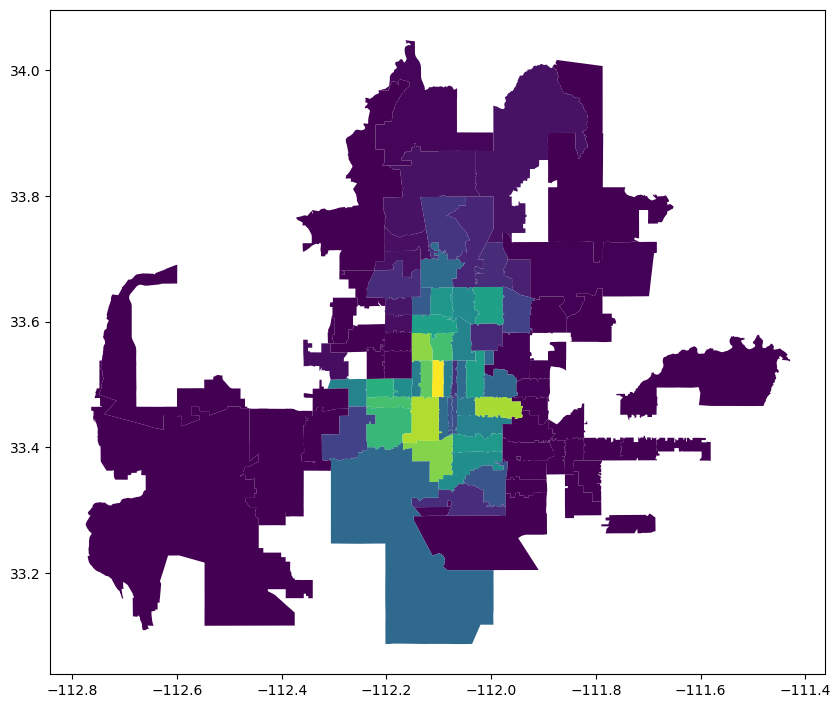

In [ ]:
merged_phx_crimes.plot(column="INC NUMBER",figsize=(10,10))

### 15. Fancy! We can clearly see that the center of Phoenix is having more crimes than suburbs, makes sense right?

The next step, we will make a more "professional" map, what i mean is that we can add a legend and change the color. Also, we would like to plot some cities on the map, just for refecence. And some people who are not familar with the PHX area will appreciate that!

### 17. Let's do this by using the `geopandas`'s `points_from_xy` method for converting a  Lat-Long table to GeoDataFrame.

In [ ]:
phx_cities = gpd.GeoDataFrame(phx_cities_df, geometry=gpd.points_from_xy(phx_cities_df.long,
                                                                         phx_cities_df.lat))

### 18. Last but not least, here is comes the "pro" map, and let's export to a image file.

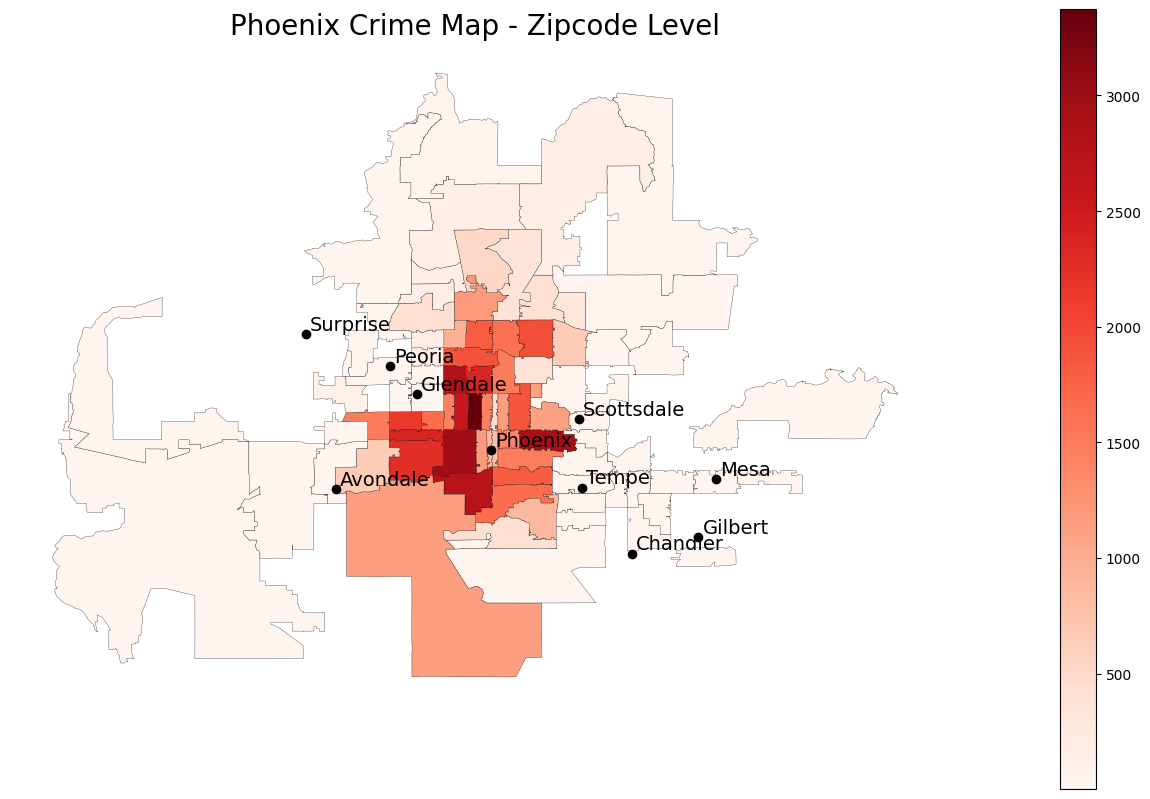

In [ ]:
fig, ax = plt.subplots(1, figsize=(12, 12))
merged_phx_crimes.plot(column="INC NUMBER",figsize=(10,10), ax=ax, cmap='Reds',edgecolor='black', linewidth=0.2)
phx_cities.plot(ax=ax,color="black")

vmin = merged_phx_crimes["INC NUMBER"].min()
vmax = merged_phx_crimes["INC NUMBER"].max()

plt.title("Phoenix Crime Map - Zipcode Level",fontsize=20)

for x, y, label in zip(phx_cities.geometry.x, phx_cities.geometry.y, phx_cities.PlaceName):
        ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points",fontsize=14)
ax.axis('off')

sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax),cmap='Reds')
sm._A = []
cax = fig.add_axes([1, 0.15, 0.03, 0.65])
fig.colorbar(sm, cax=cax)

plt.savefig("phx_crime_map.png",dpi=400,bbox_inches='tight')

In [ ]:
# save the shp file if needed
merged_phx_crimes.to_file("data/output_phoenix_crime_counts.shp")